# A/B testing

## Goal:

1. Are people more likely to form a mutual relationship with the push notification?

2. Does the mutual relationship form more quickly with the push notification? 

In [1]:
import pandas as pd
from scipy.stats import ttest_ind 
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
analytics = pd.read_csv("./data/clean_analytics.csv")

In [3]:
analytics.head()

,user_A,user_B,event_start,event_end,assignment
0,c8501e4e-7914-411b-9d0c-96a3180d0daa,4380277a-5cb8-42d7-8b21-2a7daba6906f,1.516901e+09,1.516907e+09,Control
1,1b906005-3fc7-44df-a93f-cc7afdf11bd4,6427b7f4-9223-4bfb-8d9b-e19abeeb387e,1.516901e+09,NaN,Control
2,36cbbb08-5794-43f2-92d1-c6313ac355f8,c8270f60-5ce2-4df0-9487-eb6fd1ca2369,1.516814e+09,1.516901e+09,Experiment
3,329d3d52-ce78-4d3a-8a91-f765a31e0319,5d1a38a1-39ce-4640-8c3c-bb010e9a64ab,1.514399e+09,1.514410e+09,Experiment
4,82f959c6-559d-4d51-8323-0c41a0741f4a,de77a7b7-b2af-4738-9d3b-4948d23f0f57,1.514410e+09,1.514739e+09,Control


The time to form a mutual relationship needs to be computed first.

In [4]:
analytics['time_used'] = analytics['event_end'] - analytics['event_start']

The number of events assgined to experiment and control group are

In [5]:
analytics['assignment'].value_counts()

Control       213573
Experiment     99220
Name: assignment, dtype: int64

## Hypothesis testing 1

> Are people more likely to form a mutual relationship with the push notification? 

1. Define `p1` to be the percentage of users that received the push notification and then formed a mutual relationship.

2. Define `p2` to be the percentage of users that did not received the push notification but formed a mutual relationship.  

`Null hypothesis: p1 and p2 are independent of experiment/control group split (p1 = p2)`

`Alternative hypothesis: p1 and p2 are not independent of experiment/control group split (p1 not equal p2)`

The type-I error rate is set to a standard 5%. 

**Discussion**: The chi-square indepedence test will be used here instead of the usual t-test. 

The assumption of the chi-squared test:
1. The independency of observations. 
2. Large enough observations for the test statistic to approach chi-squared distribution (>50)

The t-test requires the underlying disitrbution to be a normal distribution, while a pecentage only take values between 0 and 1. Thus, it is not ideal to use t-test on percentage. 
Given we have more than 50 observations, the Chi-square test of independence is a more apporpriate choice here. 

### computing the frequency of observations. 

In [6]:
control_index = analytics['assignment'] == "Control"
experiment_index = analytics['assignment'] == "Experiment"

mutual_index = analytics['event_end'].notna()
none_index = analytics['event_end'].isna()

In [7]:
experiment_mutual = analytics.loc[experiment_index & mutual_index].shape[0]
experiment_none = analytics.loc[experiment_index & none_index].shape[0]

control_mutual =  analytics.loc[control_index & mutual_index].shape[0]
control_none = analytics.loc[control_index & none_index].shape[0]

In [8]:
obs = [[experiment_mutual,control_mutual ],[experiment_none, control_none]]

In [9]:
chi2, p, dof, ex = chi2_contingency(obs, correction=True)

In [10]:
p

1.6286924358584332e-22

### The p-value for this independence test is  much smaller than 0.05.

**The null hypothesis is rejected.**

This means that the push notification has an effect on formation of the mutual relationship. 

In [11]:
experiment_percentage = experiment_mutual/ (experiment_mutual + experiment_none)
experiment_percentage

0.5023483168715984

In [12]:
control_percentage = control_mutual/(control_mutual + control_none)
control_percentage

0.48359109063411576

The experiment group has `50.23%` of users that formed the mutual relationship, while the control group has a  `48.35%` of users that formed the mutual relationship. 

In [13]:
(experiment_percentage - control_percentage)/control_percentage

0.03878736933074383

There is about 3.8% percent increase in forming a mutual relationship. 

The number of observations are much larger than 1000. The `power of the test is higher than the standard 0.8`.

I suspect that push notification has a negative effect on users that have a lot of followers and a positive effect on users that have less followers in forming the mutual relationship. Further analysis will be needed for this. 

## Hypothesis test 2

> Does the mutual relationship form more quickly with the push notification? 

Define `t1` to be the time used for a user in experiment group to form a mutual relationship.
Define `t2` to be the time used for a user in control group to form a mutual relationship. 

`Null hypothesis: t1 = t2`

`Alternative hypothesis: t1 < t2`

The type-I error rate is set to a standard 5%. 


**Discussion**: The goal here is to see if the mean of the time used to form a mutual relationship differs in control and experiment group. A t-test comparing the means of two independent samples is a natural choice here. 

Assumptions of t-test: 
1. Mean of the two populations compared should follow a normal distribution. 
2. The data are independently sampled. 

Given the large size of observations available and the central limit theorem, the mean should follow the normal distribution. 

The actual test used is the `Welch's t test`, which deals with unequal variance in the two populations. 


In [14]:
control_index = analytics['assignment'] == "Control"
experiment_index = analytics['assignment'] == "Experiment"

notna_index = analytics['time_used'].notna()


In [15]:
experitment_time = analytics.loc[experiment_index & notna_index, "time_used"].values
control_time = analytics.loc[control_index & notna_index, "time_used"].values

In [16]:
stats, p = ttest_ind(experitment_time, control_time, equal_var=False)

In [17]:
p

5.1605163101223499e-10

The p-value here is the p-value for two-sided test and the hypothesis we are testing is the one-sided test. The p-value for one sided test is half of the two-sided test. 

The p-value for our hypothesis test is 

In [18]:
p/2

2.580258155061175e-10

### The p-value for this independence test is  much smaller than 0.05.

**The null hypothesis is rejected.**

This means that the push notification shortened the time used for forming a mutual relationship. 

In [19]:
experitment_time.mean()

316050.27696968481

In [20]:
control_time.mean()

337767.78241126239

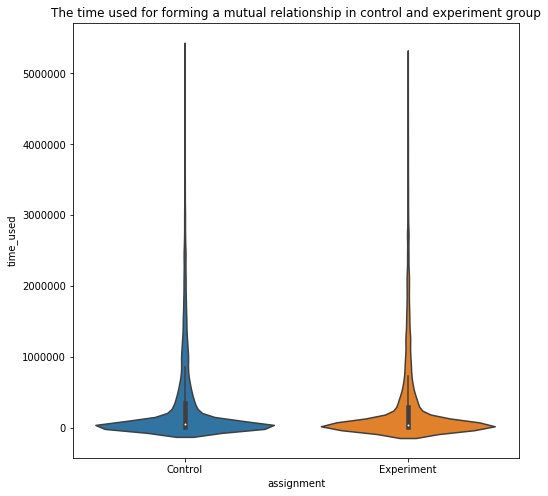

In [21]:
plt.figure(figsize = (8,8))
sns.violinplot(x = "assignment", y= "time_used" , data = analytics,kind="swarm")
plt.title("The time used for forming a mutual relationship in control and experiment group");

The underlying distribution of the time used is highly non-normal. This could leads to a spurious statistical significance. With this concern, a Wilcoxon rank-sum test should be performed. 

Assumptions of the Wilcoxon rank-sum test:
1. Data is indepedently sampled.
2. 

In [22]:
stats, p = mannwhitneyu(experitment_time, control_time, alternative = "less")

In [23]:
p

5.2862576634053449e-11

This confirms that the statistical significance from the t-test is not a spurious one. 

# Conclusion:


## 1. Are people more likely to form a mutual relationship with the push notification? `Yes`

 ## 2. Does the mutual relationship form more quickly with the push notification? `Yes`